In [2]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

image = ["00084_00.jpg", "00190_00.jpg","00782_00.jpg"]
clothes = ["05338_00.jpg", "04700_00.jpg", "02007_00.jpg"]
df = pd.DataFrame({"image": image, "clothes": clothes})
df.to_csv("data/pairs1.txt", index=False, header=False, sep=" ")

In [ ]:
!python test_generator.py --occlusion --cuda {True} --gpu_ids {0} --dataroot data/ --data_list pairs1.txt --output_dir output/

Processing images: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s]


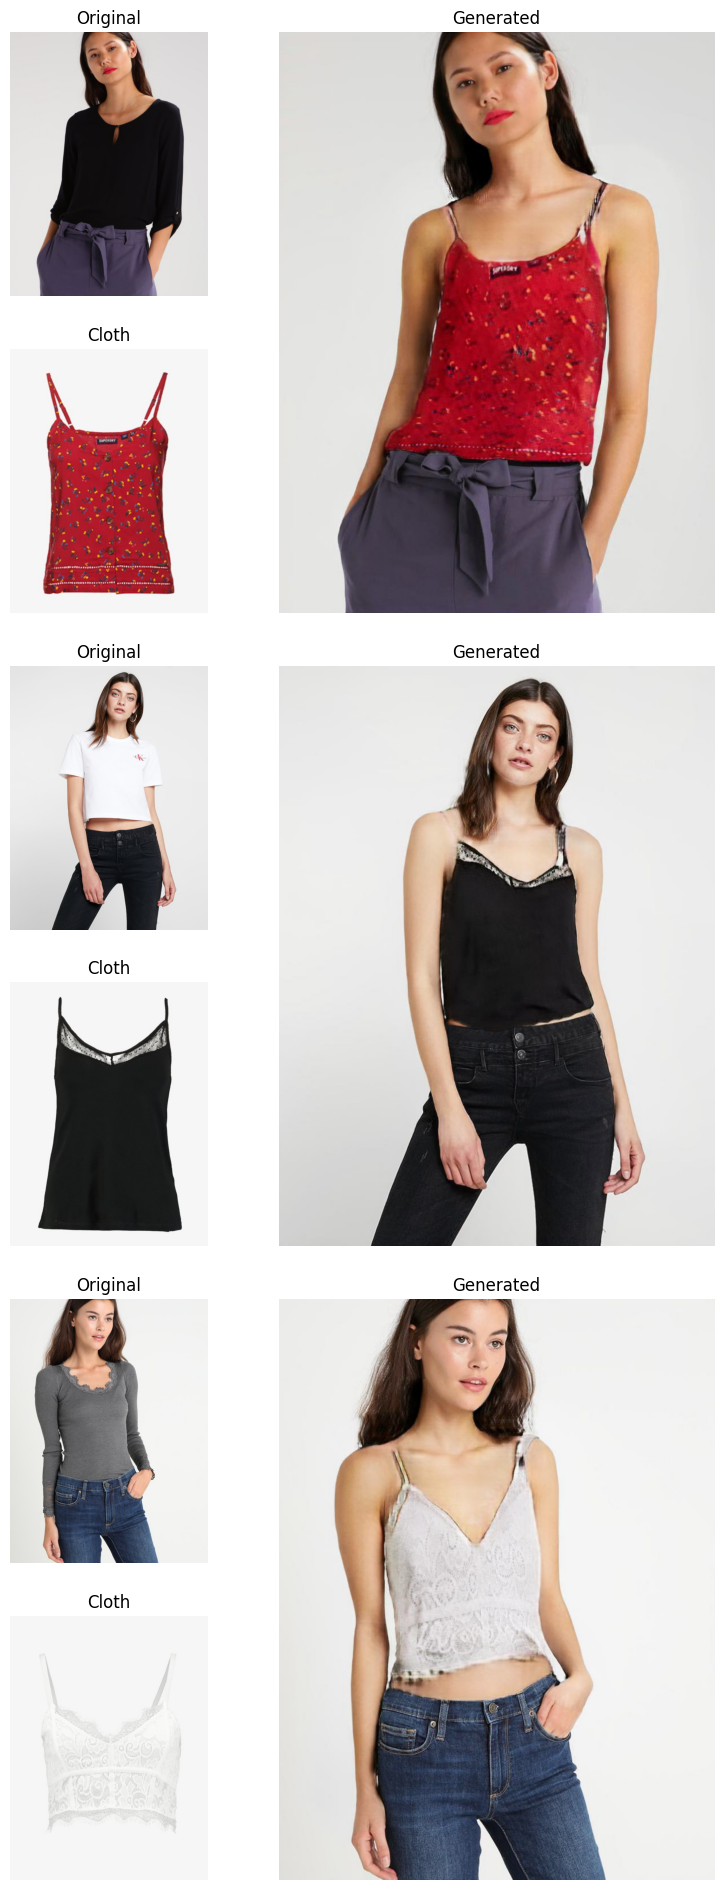

In [10]:
plt.figure(figsize=(10, 8 * len(image)))
grid = plt.GridSpec(2 * len(image), 3, wspace=0, hspace=0.2)

for idx in tqdm(range(len(image)), total=len(image), desc="Processing images"):
    img_ori = plt.imread(f"data/test/image/{image[idx]}")
    cloth = plt.imread(f"data/test/cloth/{clothes[idx]}")
    img_new = plt.imread(f"output/{image[idx][:-4]}_{clothes[idx][:-4]}.png", 0)

    plt.subplot(grid[2*idx, 0])
    plt.imshow(img_ori)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(grid[2*idx + 1, 0])
    plt.imshow(cloth)
    plt.axis("off")
    plt.title("Cloth")

    plt.subplot(grid[2*idx:2*idx+2, 1:])
    plt.imshow(img_new)
    plt.axis("off")
    plt.title("Generated")

In [13]:
import json
import numpy as np
path = r'data\test\openpose_json\00006_00_keypoints.json'
with open(path, 'r') as f:
    pose_label = json.load(f)
    pose_data = pose_label['people'][0]['pose_keypoints_2d']
    pose_data = np.array(pose_data)

In [14]:
len(pose_data)

75

In [15]:
pose_data = pose_data.reshape((-1, 3))

In [16]:
pose_data

array([[3.71684e+02, 1.67704e+02, 9.33216e-01],
       [3.74624e+02, 3.32151e+02, 8.01548e-01],
       [2.55479e+02, 3.06573e+02, 7.06157e-01],
       [1.70561e+02, 5.78504e+02, 7.83719e-01],
       [2.01665e+02, 8.56322e+02, 7.07795e-01],
       [5.04816e+02, 3.68800e+02, 7.51704e-01],
       [4.87844e+02, 5.47420e+02, 3.85496e-01],
       [4.93633e+02, 6.52287e+02, 9.51390e-02],
       [3.71680e+02, 7.54280e+02, 4.23855e-01],
       [2.81026e+02, 7.57128e+02, 3.84075e-01],
       [0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00],
       [4.62298e+02, 7.54277e+02, 3.91744e-01],
       [0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00],
       [3.29366e+02, 1.44999e+02, 9.42529e-01],
       [3.97153e+02, 1.25323e+02, 8.85736e-01],
       [3.03747e+02, 1.70585e+02, 8.80493e-01],
       [4.45421e+02, 1.44999e+02, 7.85291e-01],
       [0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.0000

In [2]:
import os

In [3]:
os.path.exists(path)

False

In [1]:
import argparse

def get_opt():
    parser = argparse.ArgumentParser()

    parser.add_argument("--gpu_ids", default="")
    parser.add_argument('-j', '--workers', type=int, default=4)
    parser.add_argument('-b', '--batch-size', type=int, default=1)
    parser.add_argument('--fp16', action='store_true', help='use amp')
    # Cuda availability
    parser.add_argument('--cuda',default=False, help='cuda or cpu')

    parser.add_argument('--test_name', type=str, default='test', help='test name')
    parser.add_argument("--dataroot", default="./data/zalando-hd-resize")
    parser.add_argument("--datamode", default="test")
    parser.add_argument("--data_list", default="test_pairs.txt")
    parser.add_argument("--output_dir", type=str, default="./Output")
    parser.add_argument("--datasetting", default="unpaired")
    parser.add_argument("--fine_width", type=int, default=768)
    parser.add_argument("--fine_height", type=int, default=1024)

    parser.add_argument('--tensorboard_dir', type=str, default='./data/zalando-hd-resize/tensorboard', help='save tensorboard infos')
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints', help='save checkpoint infos')
    parser.add_argument('--tocg_checkpoint', type=str, default='./eval_models/weights/v0.1/mtviton.pth', help='tocg checkpoint')
    parser.add_argument('--gen_checkpoint', type=str, default='./eval_models/weights/v0.1/gen.pth', help='G checkpoint')

    parser.add_argument("--tensorboard_count", type=int, default=100)
    parser.add_argument("--shuffle", action='store_true', help='shuffle input data')
    parser.add_argument("--semantic_nc", type=int, default=13)
    parser.add_argument("--output_nc", type=int, default=13)
    parser.add_argument('--gen_semantic_nc', type=int, default=7, help='# of input label classes without unknown class')
    
    # network
    parser.add_argument("--warp_feature", choices=['encoder', 'T1'], default="T1")
    parser.add_argument("--out_layer", choices=['relu', 'conv'], default="relu")
    
    # training
    parser.add_argument("--clothmask_composition", type=str, choices=['no_composition', 'detach', 'warp_grad'], default='warp_grad')
        
    # Hyper-parameters
    parser.add_argument('--upsample', type=str, default='bilinear', choices=['nearest', 'bilinear'])
    parser.add_argument('--occlusion', action='store_true', help="Occlusion handling")

    # generator
    parser.add_argument('--norm_G', type=str, default='spectralaliasinstance', help='instance normalization or batch normalization')
    parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in first conv layer')
    parser.add_argument('--init_type', type=str, default='xavier', help='network initialization [normal|xavier|kaiming|orthogonal]')
    parser.add_argument('--init_variance', type=float, default=0.02, help='variance of the initialization distribution')
    parser.add_argument('--num_upsampling_layers', choices=('normal', 'more', 'most'), default='most', # normal: 256, more: 512
                        help="If 'more', adds upsampling layer between the two middle resnet blocks. If 'most', also add one more upsampling + resnet layer at the end of the generator")

    opt = parser.parse_args(args=[])
    return opt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00190_00.jpg


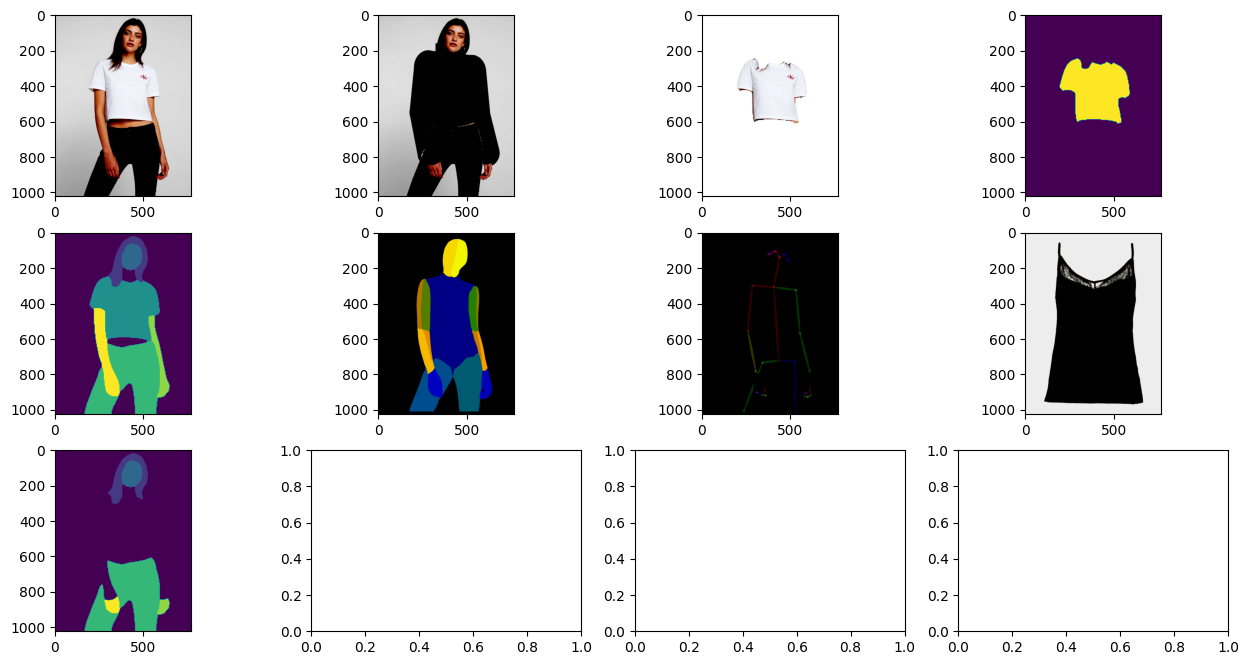

In [2]:
from cp_dataset_test import CPDatasetTest, CPDataLoader
import matplotlib.pyplot as plt

def main():
    opt = get_opt()
    opt.occlusion = True
    opt.cuda = True
    opt.gpu_ids = "0"
    opt.dataroot = "data/"
    opt.data_list = "pairs1.txt"
    opt.output_dir = "output/"

    # create test dataset & loader
    test_dataset = CPDatasetTest(opt)
    # test_loader = CPDataLoader(opt, test_dataset)
    
    sample = test_dataset[1]

    fig, ax = plt.subplots(3, 4, figsize=(16,8))
    
    ax[0,0].imshow(sample['image'].permute(1,2,0))
    ax[0,1].imshow(sample['agnostic'].permute(1,2,0))
    ax[0,2].imshow(sample['parse_cloth'].permute(1,2,0))
    ax[0,3].imshow(sample['pcm'].permute(1,2,0))
    ax[1,0].imshow(sample['parse_onehot'].permute(1,2,0))
    ax[1,1].imshow(sample['densepose'].permute(1,2,0))
    ax[1,2].imshow(sample['pose'].permute(1,2,0))
    ax[1,3].imshow(sample['cloth']['unpaired'].permute(1,2,0))
    ax[2,0].imshow(sample['parse_agnostic_onehot'].permute(1,2,0))
    
    return sample



# if __name__ == "__main__":
sample = main()
print(sample['im_name'])

In [7]:
sample['parse_agnostic'].sum(axis=0).shape

torch.Size([1024, 768])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


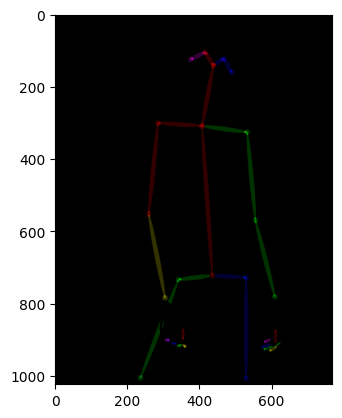

In [29]:
plt.imshow(sample['pose'].permute(1,2,0))

In [33]:
keypoints = sample['pose_data']

In [18]:
connections = [
    # Head / Face
    (0, 15),   # Nose → R-Eye
    (0, 16),   # Nose → L-Eye
    (15, 17),  # R-Eye → R-Ear
    (16, 18),  # L-Eye → L-Ear

    # Upper Body
    (0, 1),    # Nose → Neck
    (1, 5),    # Neck → L-Shoulder
    (1, 2),    # Neck → R-Shoulder

    # Left Arm
    (5, 6),    # L-Shoulder → L-Elbow
    (6, 7),    # L-Elbow → L-Wrist

    # Right Arm
    (2, 3),    # R-Shoulder → R-Elbow
    (3, 4),    # R-Elbow → R-Wrist

    # Torso / Hips
    (1, 8),    # Neck → Mid-Hip
    (8, 12),   # Mid-Hip → L-Hip
    (8, 9),    # Mid-Hip → R-Hip

    # Left Leg
    (12, 13),  # L-Hip → L-Knee
    (13, 14),  # L-Knee → L-Ankle

    # Right Leg
    (9, 10),   # R-Hip → R-Knee
    (10, 11),  # R-Knee → R-Ankle

    # Left Foot
    (14, 19),  # L-Ankle → L-BigToe
    (14, 20),  # L-Ankle → L-SmallToe
    (14, 21),  # L-Ankle → L-Heel

    # Right Foot
    (11, 22),  # R-Ankle → R-BigToe
    (11, 23),  # R-Ankle → R-SmallToe
    (11, 24),  # R-Ankle → R-Heel
]


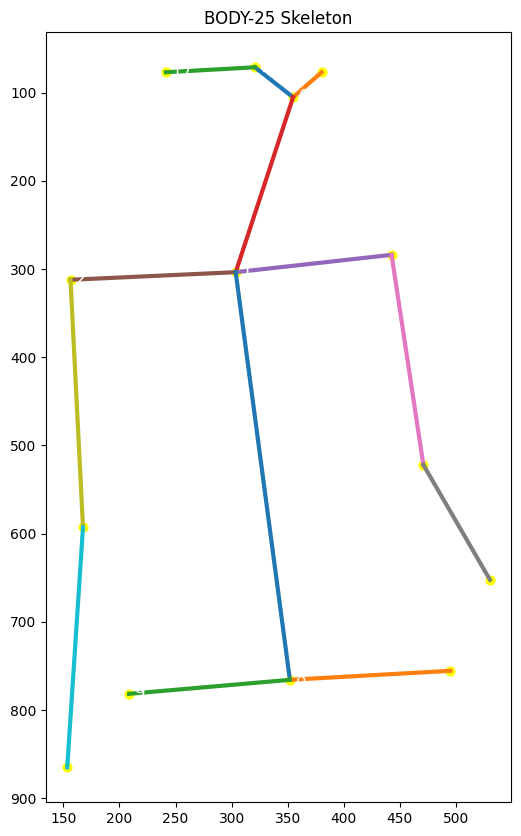

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Your keypoints
keypoints = sample['pose_data']

# BODY-25 connections
# connections = [
#     (0,15), (0,16), (15,17), (16,18),
#     (0,1), (1,5), (1,2),
#     (5,6), (6,7),
#     (2,3), (3,4),
#     (1,8), (8,12), (8,9),
#     (12,13), (13,14),
#     (9,10), (10,11),
#     (14,19), (14,20), (14,21),
#     (11,22), (11,23), (11,24),
# ]

def plot_skeleton(connections, title="Skeleton"):
    plt.figure(figsize=(6,10))
    plt.gca().invert_yaxis()

    # plot keypoints with index labels
    for i,(x,y) in enumerate(keypoints):
        if x>0 and y>0:
            plt.scatter(x, y, color="yellow", s=40)
            plt.text(x+5, y+5, str(i), color="white", fontsize=12)

    # plot limbs
    for (i,j) in connections:
        if np.all(keypoints[i]>0) and np.all(keypoints[j]>0):
            xs = [keypoints[i,0], keypoints[j,0]]
            ys = [keypoints[i,1], keypoints[j,1]]
            plt.plot(xs, ys, linewidth=3)

    plt.title(title)
    plt.show()

plot_skeleton(connections, "BODY-25 Skeleton")


In [25]:
sample['im_name']

'00782_00.jpg'

In [ ]:
# curl -X POST https://login.mcinext.org:8090/httpclient.html \
#   -d "username=Y.sharif" \
#   -d "password=Ysh@336699" \
#   -c cookies.txt
# curl -X POST https://login.mcinext.org:8090/httpclient.html -d "username=Y.sharif" -d "password=Ysh@336699" -c cookies.txt